# Load Results

In [1]:
# to reload local packages when debugging
%load_ext autoreload
%autoreload 2

%cd /mnt/c/Users/resha/Documents/Github/balancing_framework/

import pickle
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

def plot_metric(result_sets, metric, focused_form, title):
    plt.figure(figsize=(10, 4))  
    df = pd.DataFrame()

    for result_set_data_form, result_set_data in result_sets.items():
        means1 = np.array([ x[f'{metric}_mean'] for x in result_set_data ])
        # std1 = np.array([ x[f'{metric}_std'] for x in result_set_data ])
        timestamps1 = np.array([ x['last_ts'] for x in result_set_data ])

        # print(set_form_title)
        # print(f'Average Value: {np.mean(means1):.5g}, Highest Value: {np.max(means1):.5g}, Lowest Value: {np.min(means1):.5g}')
        df = pd.concat([df, pd.DataFrame({'mean_acc': np.mean(means1), 'low_acc': np.min(means1), 'high_acc': np.max(means1)}, index=[result_set_data_form])], axis=0)

        if result_set_data_form == focused_form:
            sns.lineplot(x=timestamps1, y=means1, label=result_set_data_form, linewidth=1)
        else:
            sns.lineplot(x=timestamps1, y=means1, label=result_set_data_form, linewidth=1)
        
        # plt.fill_between(timestamps1, means1 - std1, means1 + std1, alpha=0.3, label=f'{result_set_data_form} Std Dev')

    # plt.title(title) #(f'{title}: {metric}')
    plt.xlabel('Timestamp')
    plt.ylabel(f'{metric}')
    # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.legend(fontsize=12, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=2)
    
    plt.xticks(fontsize=14,rotation=45) # Adjust X-axis tick label size
    plt.yticks(fontsize=14) # Adjust Y-axis tick label size
    plt.xlabel('Timestamp', fontsize=20)
    plt.ylabel('Accuracy', fontsize=20)

    # plt.tight_layout()  
    plt.savefig(f'figures/{title}_{metric}.png', bbox_inches='tight')
    # plt.show()
    
    df = df.reset_index().rename(columns={'index': 'data_form'})
    return df, plt


/mnt/c/Users/resha/Documents/Github/balancing_framework


In [2]:

import os
# datasets = ['electricity', 'm4_daily_dataset', 'm4_daily_dataset_gluonts',  'london_smart_meters_without_missing', 'weather_dataset']
datasets = ['m4_daily_dataset']

def load_results(datasets):
    
    ar_res = {}
    cr_res = {}
    # for dataset in os.listdir('/mnt/c/Users/resha/Documents/Github/balancing_framework/results/monash_picked_single_series_runs'):
    for dataset in datasets:
        res_dir = f'/mnt/c/Users/resha/Documents/Github/balancing_framework/results/monash_picked_single_series_runs/{dataset}'
        ar_res[dataset] = {}
        cr_res[dataset] = {}
        for dir in os.listdir(res_dir):
            if '.' in dir:
                continue

            series_num = dir.split('[')[0].split('_')[-2]
            if series_num not in ar_res[dataset].keys():
                ar_res[dataset][series_num] = {}
                cr_res[dataset][series_num] = {}

            forms_string = dir.split(']')[0].split('[')[1]
            # map form strings to print friendly
            type_map = {"'o'": 'original', "'fd'": 'frac_diff', "'fod'": 'first_order_diff',
                        "'tao'": 'original_ta', "'tafd'": 'frac_diff_ta', "'tafod'": 'first_order_diff_ta',}
            forms_string = ' + '.join([type_map[abbr] for abbr in forms_string.replace(" ", "").split(",")])

            with open(f'{res_dir}/{dir}/adaptation_results.pkl', 'rb') as f:
                ar = pickle.load(f)
            with open(f'{res_dir}/{dir}/consolidation_results.pkl', 'rb') as f:
                cr = pickle.load(f)

            # ar_res[dataset][series_num].append((forms_string, ar))
            # cr_res[dataset][series_num].append((forms_string, cr))
            ar_res[dataset][series_num][forms_string] = ar
            cr_res[dataset][series_num][forms_string] = cr
    return ar_res, cr_res


# Plots

In [3]:

def plot_res_build_resdf(ar_res, cr_res, metric='accuracy'):
    results = pd.DataFrame()
    base_dir = f'/mnt/c/Users/resha/Documents/Github/balancing_framework/results/monash_picked_single_series_runs/'
    focused_form = 'original + frac_diff'

    for key, value in ar_res.items(): # item = dataset_name, series dict
        dataset = key
        res_dir = f'{base_dir}/{dataset}'
        for key, value in value.items(): # item = series_num, list of results pulled
            series_num = key
            title = f'adap_{dataset}_{series_num}' #f'Comparison of Adaptation {metric} for {dataset}_{series_num}'
            df, plt = plot_metric(value, metric, focused_form, title)
            df['dataset'] = dataset
            df['value_type'] = 'adaptation'
            df['series_num'] = series_num
            results = pd.concat([results, df], ignore_index=True)
            plt.savefig(f'{res_dir}/ada_comp_{metric}_{series_num}.png')
    for key, value in cr_res.items(): # item = dataset_name, series dict
        dataset = key
        for key, value in value.items(): # item = series_num, list of results pulled
            series_num = key
            title = f'cons_{dataset}_{series_num}' #f'Comparison of Consolidation {metric} for {dataset}_{series_num}'
            df, plt = plot_metric(value, metric, focused_form, title)
            df['dataset'] = dataset
            df['value_type'] = 'consolidation'
            df['series_num'] = series_num
            results = pd.concat([results, df], ignore_index=True)
            plt.savefig(f'{res_dir}/cons_comp_{metric}_{series_num}.png')

    return results

# Stability Estimate

In [4]:
import itertools
def append_stab(res_pack, results, value_type, metric='accuracy'):
    metric_key = f'{metric}_mean'
    form_keys = ['original', 'frac_diff', 'first_order_diff', 'original_ta', 'frac_diff_ta', 'first_order_diff_ta'] # individual forms
    form_keys = [' + '.join(combo) 
        for r in range(1, len(form_keys) + 1) 
        for combo in itertools.combinations(form_keys, r)
    ] # all combinations of the forms
    
    for dataset in res_pack.keys():
        for series_num in res_pack[dataset].keys():
            for form in form_keys:
                if form in res_pack[dataset][series_num].keys():
                    metric_vals = [ res[metric_key] for res in res_pack[dataset][series_num][form] ]
                    var = np.var(metric_vals)
                    mean = np.mean(metric_vals)
                    coeff_var = (np.std(metric_vals) / np.mean(metric_vals)) * 100
                    # append the values to the passed results df
                    idx = results.loc[results['dataset'] == dataset].loc[ results['value_type'] == value_type].loc[results['series_num'] == series_num].loc[results['data_form'] == form].index
                    results.loc[idx, 'stab_var'] = var
                    results.loc[idx, 'stab_mean'] = mean
                    results.loc[idx, 'stab_coeff_var'] = coeff_var
    return results

# Run

In [5]:
# convert index of missing timestamps to datetime using starting point
def impute_ts(res_pack, dataset, starting_point, dataset_length):
    date_lookup = pd.date_range(start=starting_point, periods=dataset_length, freq='D').to_list()
    for series in res_pack[dataset].keys():
        for data_form in res_pack[dataset][series].keys():
            for i, res in enumerate(res_pack[dataset][series][data_form]):
                if type(res['last_ts']) == int or type(res['last_ts']) == np.int64:
                    res_pack[dataset][series][data_form][i]['last_ts'] = date_lookup[res['last_ts']]
    return res_pack

,data_form,mean_acc,low_acc,high_acc,dataset,value_type,series_num,stab_var,stab_mean,stab_coeff_var
0,original + frac_diff + first_order_diff,0.946667,0.904301,1.000000,m4_daily_dataset,adaptation,1165,8.514742e-04,0.946667,3.082398
1,original + frac_diff,0.956984,0.900000,0.982258,m4_daily_dataset,adaptation,1165,4.877468e-04,0.956984,2.307771
2,original + first_order_diff,0.478971,0.403226,0.529787,m4_daily_dataset,adaptation,1165,1.310804e-03,0.478971,7.558917
3,original,0.536132,0.445161,0.658065,m4_daily_dataset,adaptation,1165,3.442196e-03,0.536132,10.943245
4,frac_diff,0.670098,0.532900,0.854700,sp500_run1,adaptation,1,3.504829e-03,0.670098,8.834766
5,first_order_diff,0.570897,0.474900,0.738600,sp500_run1,adaptation,1,2.660746e-03,0.570897,9.035332
6,original,0.689450,0.561100,0.859900,sp500_run1,adaptation,1,3.987213e-03,0.689450,9.158661
7,original + frac_diff + first_order_diff,0.790216,0.667300,0.928000,sp500_run3,adaptation,1,3.246863e-03,0.790216,7.210841
8,original + frac_diff,0.822602,0.737100,0.937700,sp500_run3,adaptation,1,2.125265e-03,0.822602,5.604238
9,original + first_order_diff,0.679900,0.556900,0.852600,sp500_run3,adaptation,1,3.922744e-03,0.679900,9.211919


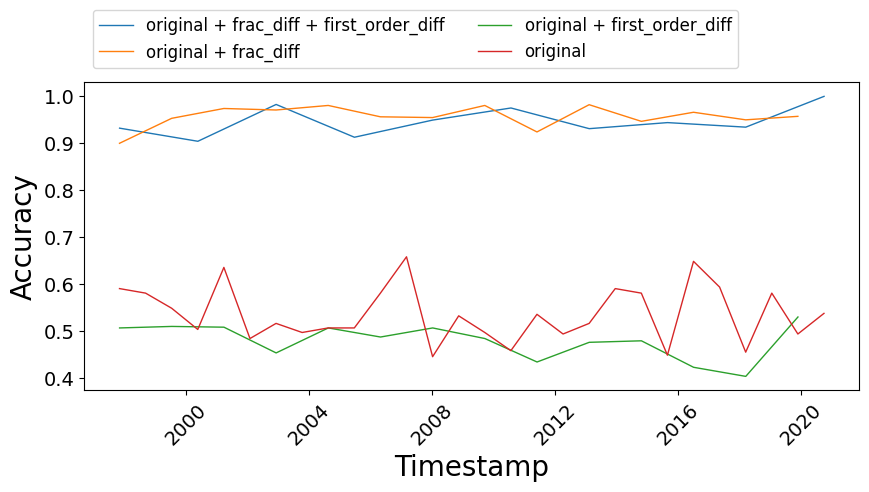

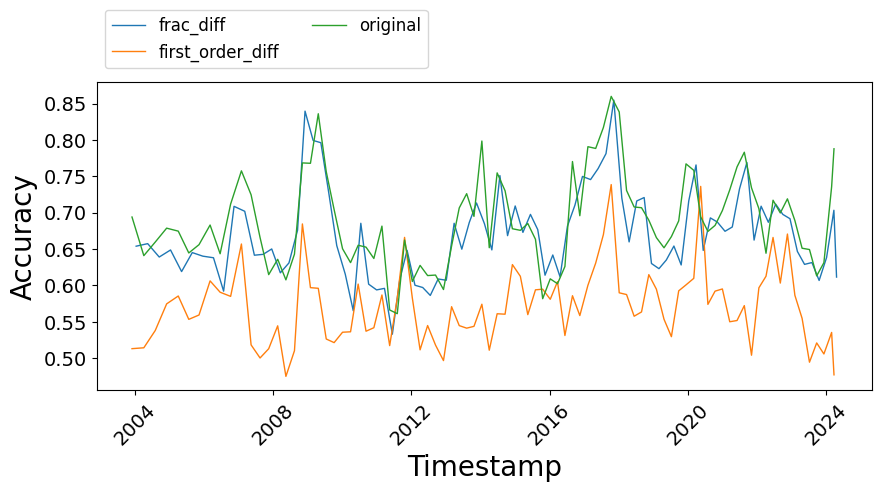

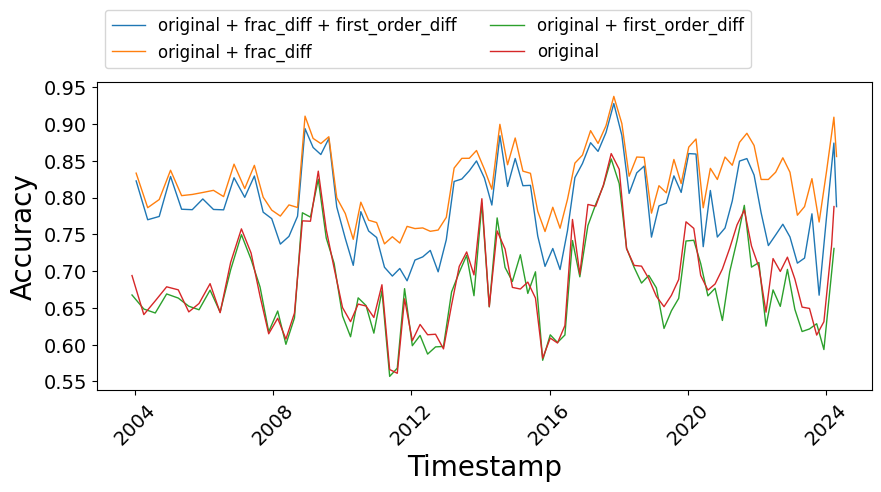

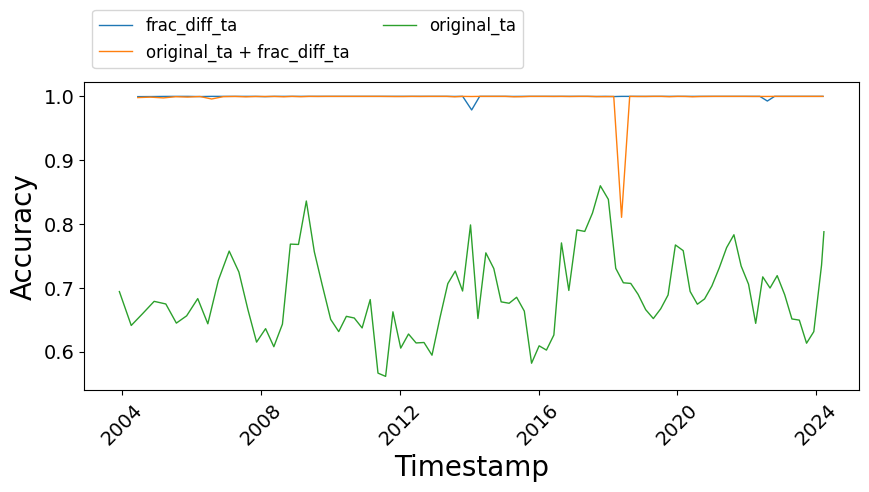

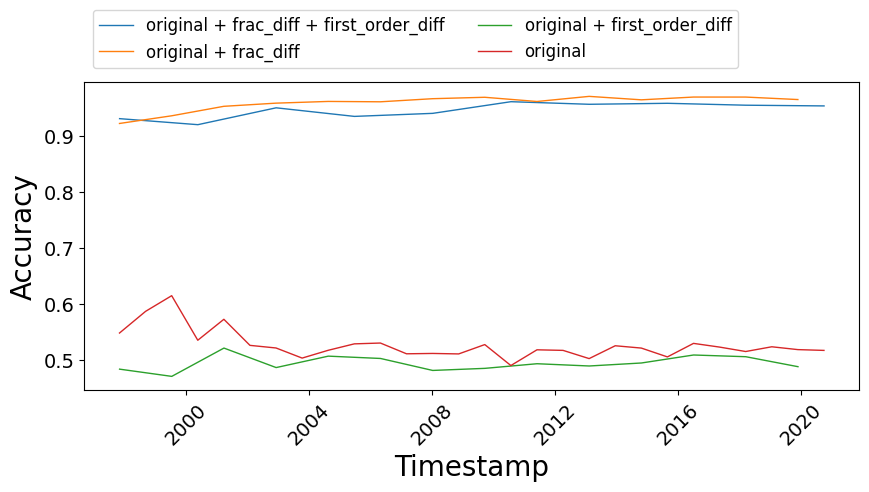

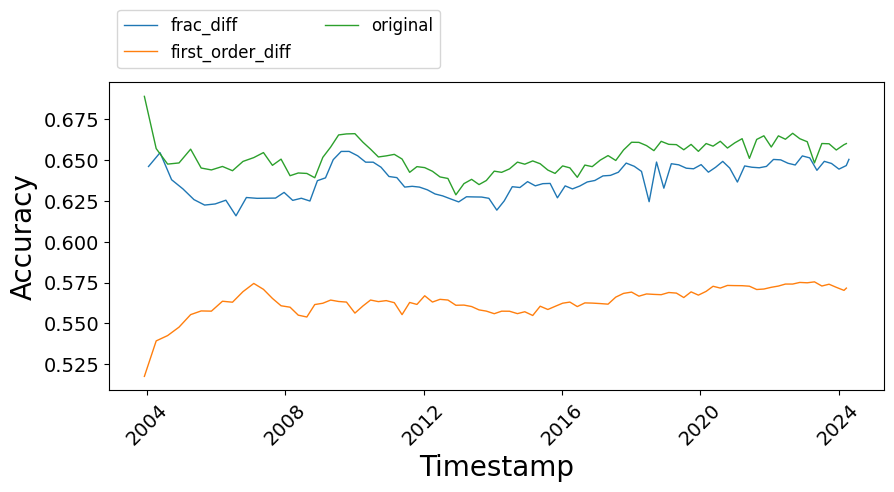

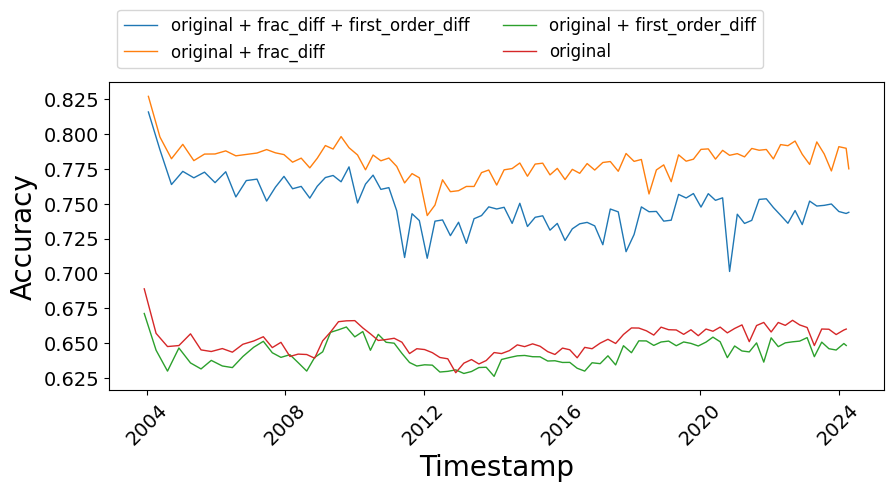

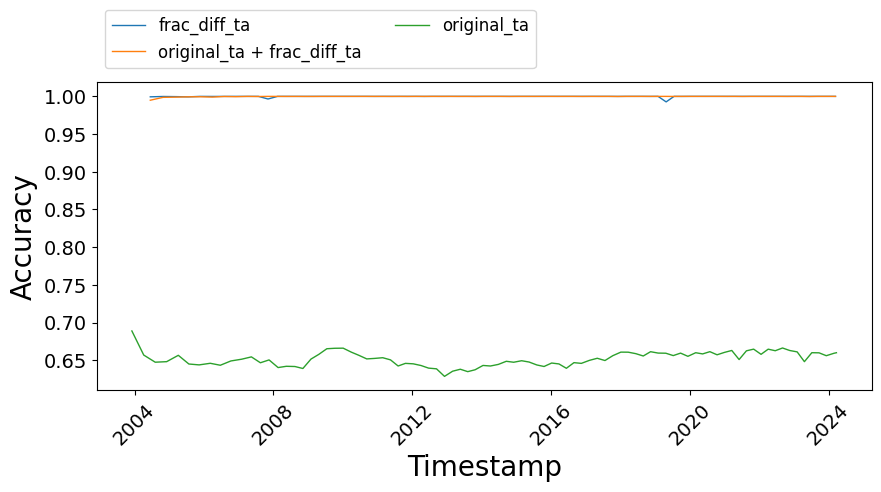

In [6]:
datasets = ['m4_daily_dataset', 'sp500_run1', 'sp500_run3', 'sp500_run4']

ar_res, cr_res = load_results(datasets)

ar_res = impute_ts(ar_res, 'm4_daily_dataset', '1997-07-22', 8531)
cr_res = impute_ts(cr_res, 'm4_daily_dataset', '1997-07-22', 8531)

results = plot_res_build_resdf(ar_res, cr_res)

results = append_stab(ar_res, results, 'adaptation')
results = append_stab(cr_res, results, 'consolidation')
results

In [8]:
pd.set_option('display.float_format', '{:.10f}'.format)

In [41]:
1-(1.395/4.853)

0.7125489388007418

In [40]:
95.95-52.71

43.24

In [36]:
results[results['dataset'] == 'm4_daily_dataset']

,data_form,mean_acc,low_acc,high_acc,dataset,value_type,series_num,stab_var,stab_mean,stab_coeff_var
0,original + frac_diff + first_order_diff,0.9466666667,0.9043010753,1.0000000000,m4_daily_dataset,adaptation,1165,0.0008514742,0.9466666667,3.0823975498
1,original + frac_diff,0.9569835278,0.9000000000,0.9822580645,m4_daily_dataset,adaptation,1165,0.0004877468,0.9569835278,2.3077711709
2,original + first_order_diff,0.4789709775,0.4032258065,0.5297872340,m4_daily_dataset,adaptation,1165,0.0013108035,0.4789709775,7.5589173893
3,original,0.5361319124,0.4451612903,0.6580645161,m4_daily_dataset,adaptation,1165,0.0034421959,0.5361319124,10.9432451870
14,original + frac_diff + first_order_diff,0.9464042523,0.9204301075,0.9614695341,m4_daily_dataset,consolidation,1165,0.0001700276,0.9464042523,1.3777898141
15,original + frac_diff,0.9594827002,0.9225806452,0.9709677419,m4_daily_dataset,consolidation,1165,0.0001792780,0.9594827002,1.3954888426
16,original + first_order_diff,0.4943834920,0.4709677419,0.5215053763,m4_daily_dataset,consolidation,1165,0.0001680167,0.4943834920,2.6218765439
17,original,0.5271343382,0.4903225806,0.6150537634,m4_daily_dataset,consolidation,1165,0.0006545012,0.5271343382,4.8532639727


In [35]:
idx = results.loc[results['dataset'] == 'm4_daily_dataset'].loc[ results['value_type'] == 'adaptation'].index
results.loc[idx,'stab_var'] = 0.3

In [8]:
# results.drop(columns=['stab_var', 'stab_mean','series_num'], inplace=True)
results.to_csv('results_runs1_to_4.csv', index=False)

# Tabulate gluonts results

In [49]:
import re
import pandas as pd

def parse_to_df_simple(file_path):
    # This single regex pattern captures all required fields for one block.
    # It uses named capture groups for clear column mapping.
    pattern = re.compile(
        r'(?P<Model>\w+)\s+(?P<Trials>\d+).*?on\s+(?P<Dataset>\w+)\s+(?P<Save_Label>\w+)\s+data form.*?'
        r'Runtime:\s*(?P<Runtime>[\d\.]+)\s+minutes.*?'
        r'Prediction length:\s*(?P<Pred_Len>\d+),\s*Context length:\s*(?P<Context_Len>\d+).*?'
        r'Params:\s*(?P<Params>\{.*?\}).*?'
        r'MASE MEAN:\s*(?P<MASE_MEAN>[\d\.\-]+)\s+MASE STD:\s*(?P<MASE_STD>[\d\.\-]+).*?'
        r'sMAPE MEAN:\s*(?P<sMAPE_MEAN>[\d\.\-]+)\s+sMAPE STD:\s*(?P<sMAPE_STD>[\d\.\-]+).*?'
        r'RMSE MEAN:\s*(?P<RMSE_MEAN>[\d\.\-]+)\s+RMSE STD:\s*(?P<RMSE_STD>[\d\.\-]+)',
        re.DOTALL | re.MULTILINE
    )

    with open(file_path, 'r') as f:
        content = f.read()

    # Find all matches (one for each result block)
    parsed_data = [m.groupdict() for m in pattern.finditer(content)]

    # Create DataFrame and convert appropriate columns to numeric types
    df = pd.DataFrame(parsed_data)
    numeric_cols = df.columns.difference(['Model', 'Dataset', 'Save_Label', 'Params'])
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)
    
    return df

# Example Usage:
file_path = "gluonts_results.txt"
# Assume the file exists and has data
df_results = parse_to_df_simple(file_path)

# Output
print(df_results.head())
# df_results.to_csv("gluonts_results.csv", index=False) # Uncomment to save to CSV

         Model  Trials           Dataset       Save_Label     Runtime  \
0  transformer      15  m4_daily_dataset  original_values  279.034945   
1  transformer      15  m4_daily_dataset        fd_in_fdr  314.083436   
2  transformer      15  m4_daily_dataset  original_values  237.008468   
3  transformer      15  m4_daily_dataset        fd_in_fdr  195.123166   
4  feedforward      15  m4_daily_dataset  original_values   38.241892   

   Pred_Len  Context_Len                                             Params  \
0       140           90  {'model_dim_num_heads_pair': (32, 4), 'inner_f...   
1       140           90  {'model_dim_num_heads_pair': (20, 2), 'inner_f...   
2        14            9  {'model_dim_num_heads_pair': (41, 1), 'inner_f...   
3        14            9  {'model_dim_num_heads_pair': (60, 1), 'inner_f...   
4        14            9  {'num_layers': 4, 'hidden_dim_0': 15, 'hidden_...   

   MASE_MEAN  MASE_STD  sMAPE_MEAN  sMAPE_STD   RMSE_MEAN    RMSE_STD  
0  15.523798  

In [72]:
df_1_dataset = df_results[df_results['Dataset'] == 'sp500'] # m4_daily_dataset
# m4_res = m4_res[m4_res['Pred_Len'] == 14]
df_1_dataset.drop(columns=['Trials', 'Runtime', 'Params', 'sMAPE_MEAN', 'sMAPE_STD', 'RMSE_MEAN', 'RMSE_STD'], inplace=True)
df_1_dataset

/tmp/ipykernel_3340/4238173228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1_dataset.drop(columns=['Trials', 'Runtime', 'Params', 'sMAPE_MEAN', 'sMAPE_STD', 'RMSE_MEAN', 'RMSE_STD'], inplace=True)


,Model,Dataset,Save_Label,Pred_Len,Context_Len,MASE_MEAN,MASE_STD
33,transformer,sp500,original_values,12,390,0.415443,0.186117
34,transformer,sp500,fd_target_values,12,390,0.161628,0.042724
35,transformer,sp500,fd_in_fdr,12,390,0.697601,0.213665
36,transformer,sp500,fd_target_values,78,390,0.369107,0.171328
37,transformer,sp500,fd_in_fdr,78,390,0.992189,0.322756
38,transformer,sp500,original_values,78,390,0.894987,0.199357


In [74]:
df = df_1_dataset
# --- Step 2: Combine Mean/STD and Pivot the Data ---

# Define metric roots (MASE, sMAPE, RMSE) and all ID columns
metrics = ['MASE']
id_cols = ['Model', 'Dataset', 'Pred_Len', 'Context_Len']
pivot_cols = id_cols + ['Save_Label']

# 1. Combine all Mean and STD columns into single string columns
for m in metrics:
    df[m] = df[f'{m}_MEAN'].round(4).astype(str) + ' ± ' + df[f'{m}_STD'].round(4).astype(str)
    df = df.drop(columns=[f'{m}_MEAN', f'{m}_STD'])


# 2. Reshape to put Save_Label into column headers
# We use a merge loop instead of melt/pivot to simplify the code length
df_pivoted = df[id_cols].drop_duplicates().set_index(id_cols) # Start with unique ID rows

for label in df['Save_Label'].unique():
    # Filter the DataFrame for the current label
    df_temp = df[df['Save_Label'] == label].set_index(id_cols)
    
    # Rename metric columns with the label prefix
    df_temp = df_temp[metrics].rename(
        columns=lambda x: f'{label}' # _{x} if using multiple metrics
    )
    
    # Merge into the pivoted result
    df_pivoted = df_pivoted.merge(df_temp, left_index=True, right_index=True, how='left')

# 3. Final cleanup
df_final = df_pivoted.reset_index()

df_final.drop_duplicates(subset='original_values', keep='last', inplace=True) # duplicates in this case due to rerun after changing FD type, on m4 only
df_final.drop(columns=['Dataset'], inplace=True)

/tmp/ipykernel_3340/1090424233.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[m] = df[f'{m}_MEAN'].round(4).astype(str) + ' ± ' + df[f'{m}_STD'].round(4).astype(str)


In [75]:
df_final.sort_values(by=['Model', 'Pred_Len', 'Context_Len'], inplace=True)
df_final.reset_index(drop=True, inplace=True)
df_final

,Model,Pred_Len,Context_Len,original_values,fd_target_values,fd_in_fdr
0,transformer,12,390,0.4154 ± 0.1861,0.1616 ± 0.0427,0.6976 ± 0.2137
1,transformer,78,390,0.895 ± 0.1994,0.3691 ± 0.1713,0.9922 ± 0.3228


# Extra Plots

In [25]:
ar_res.keys()

dict_keys(['m4_daily_dataset', 'sp500_run1', 'sp500_run3', 'sp500_run4'])

In [85]:
dataset = 'sp500_run3' 
series_num = '1'
data_form = 'original + frac_diff' # 'original_ta + frac_diff_ta'#
metric = 'mase_mean'
metric= 'accuracy_mean'
ar_mases = [res[metric] for res in ar_res[dataset][series_num][data_form]]
ar_ts = [ res['last_ts'] for res in ar_res[dataset][series_num][data_form] ]
cr_mases = [res[metric] for res in cr_res[dataset][series_num][data_form]]
cr_ts = [ res['last_ts'] for res in cr_res[dataset][series_num][data_form] ]

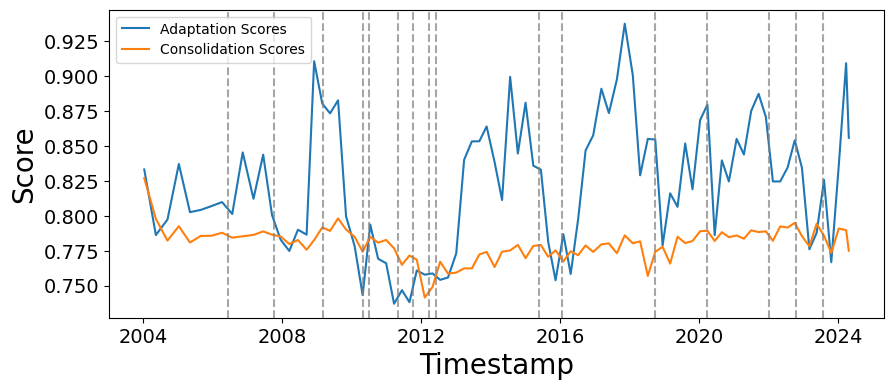

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
# sns.set_theme() 

sns.lineplot(y=ar_mases, x=ar_ts, label='Adaptation Scores') 
sns.lineplot(y=cr_mases, x=cr_ts, label='Consolidation Scores')

for timestamp in regs:
    plt.axvline(x=timestamp, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

# Set the title and axis labels using matplotlib functions
# plt.title('Comparison of Differencing Effect on Non-Stationary Series', fontsize=24, pad=5)
plt.xlabel('Timestamp', fontsize=20)
plt.ylabel('Score', fontsize=20)

# Size the tick labels
plt.xticks(fontsize=14) # Adjust X-axis tick label size
plt.yticks(fontsize=14) # Adjust Y-axis tick label size

plt.legend()
plt.savefig(f'figures/a_vs_c_sp500_run3_o_fd.png', bbox_inches='tight')
plt.show()

In [82]:
# PZ

from pz_algorithm import pz_algorithm

import pandas as pd
import pickle

with open('/mnt/c/Users/resha/Documents/Github/balancing_framework/spy5m_bintp_labelled.pkl', 'rb') as f:
    df_original = pickle.load(f) # ohlv + transactions + labels + bintp labels
df = df_original[["volume", "vwap", "open", "close", "high", "low", "transactions", "tp_0.004"]].rename(columns={"tp_0.004": "label"}) # 0.01 0.001
# df

peaks, troughs = pz_algorithm(df['close'], iterations=6)
print(f'Peaks: {len(peaks)}, Troughs: {len(troughs)}')

Peaks: 8, Troughs: 8


In [36]:
regs = pd.concat([peaks, troughs]).sort_index().index

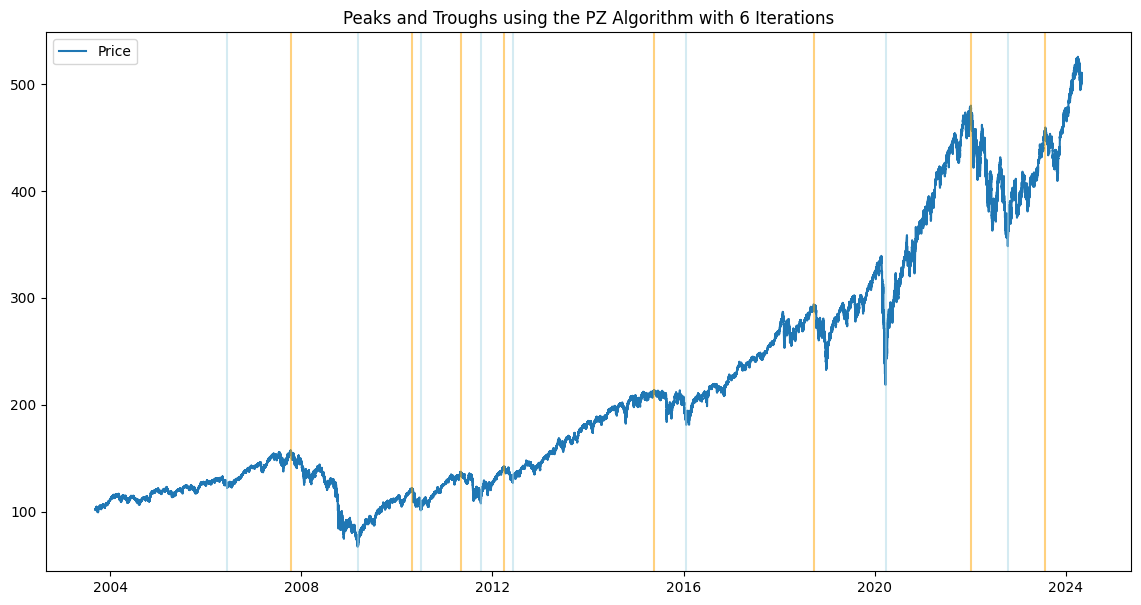

In [21]:

# plot the peaks and troughs
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.plot(df['close'], label='Price')
# use orange vertical lines for peaks and light blue vertical lines for troughs
for peak in peaks.index:
    plt.axvline(peak, color='orange', alpha=0.5)
for trough in troughs.index:
    plt.axvline(trough, color='lightblue', alpha=0.5)
plt.title('Peaks and Troughs using the PZ Algorithm with 6 Iterations')
plt.legend()
plt.show()